# Overview

This notebook demonstrates a 'retrieve and rank' approach to new product categorization.

It consists of the following steps, each of which is expanded upon in the respective sections below:

1. Embed product description and image

2. **Retrieve** nearest neighbors in embedding space

3. Fetch corresponding categories for nearest neighbors

4. Feed categories as as candidates to an LLM, ask it to **rank** by relevance to user input product description

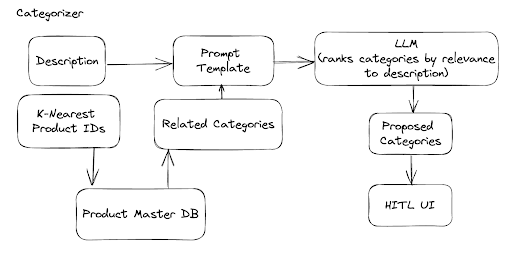

# Motivation

When a new product is added to inventory at a retailer it gets added to a product catalog. Correct placement in a catalog can impact which customers find or are presented with the product - ultimately impacting sales. Building a model that can turn product descriptions and images into correct categorization within a product catalog can help automate product placement.

# Dataset

[Mercari](https://www.mercari.com/) is a popular marketplace app with 5M users in the US and 20M in Japan. This dataset is approved for internal use only.

While the raw dataset has ~20M roles, we use a [sampled dataset](https://pantheon.corp.google.com/bigquery?ws=!1m5!1m4!4m3!1ssolutions-2023-mar-107!2smercari!3s13K_synthetic_attributes_embeddings) which contains ~13K rows.

# Setup

### Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [ ]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [ ]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Authenticate

If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

If you are using Vertex AI Workbench, you will not require additional authentication.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

### Config

In [ ]:
# GCP
PROJECT = 'solutions-2023-mar-107'
LOCATION = 'us-central1'

# Vertex Vector Store
ENDPOINT_ID = '8767655253467201536'
DEPLOYED_INDEX = 'muiltimodal_13K_train'
NUM_NEIGHBORS = 7 # Fetches NUM_NEIGBHORS for both text and image embeddings

# BigQuery
MASTER_PRODUCT_TABLE = 'solutions-2023-mar-107.mercari.13K_synthetic_attributes_embeddings'
TEST_SET_TABLE = 'solutions-2023-mar-107.mercari.13K_synthetic_attributes_embeddings_golden_test'

# 0. User Input

End user provides an image and a short product description. Feel free to modify with your own

In [ ]:
DESCRIPTION = "New Men’s Nike Sportswear Storm-Fit Hooded Puffer Jacket   Retail~$200  The down insulation offers a lightweight construction that packs in the heat. Nike Storm-FIT technology resists elements like wind and water to help keep you comfortable in harsh weather conditions. Zippered hand pockets offer secure storage for essentials like your phone, wallet and keys. Raised silicone logo patch. Storm-FIT embroidery on the cuff highlights the premium construction. Standard fit for a relaxed, easy feel  Men's Size XXL Condition: New with tags  Color: Grey  Please feel free to ask questions   Thanks for looking"
IMAGE_URL = 'gs://genai-product-catalog/mercari_images_13K/m92378019981_1.jpg'

# 1. Embed

The system will use multimodal embeddings to create a semantic vector representations of the product description and product image. We leverage the [Vertex AI Embedding API](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-image-embeddings) for this.

It is important to note that text and image data is not fused into a single embedding. The service provides text-only and image-only embeddings, but they share an embedding space. In other words the text 'cat' and a picture of a cat should return similar embeddings.

In [ ]:
import base64
from google.cloud import aiplatform
from google.protobuf import struct_pb2
from functools import cache
import time
import typing


# Inspired from https://stackoverflow.com/questions/34269772/type-hints-in-namedtuple.
class EmbeddingResponse(typing.NamedTuple):
  text_embedding: typing.Sequence[float]
  image_embedding: typing.Sequence[float]


class EmbeddingPredictionClient:
  """Wrapper around Prediction Service Client."""
  def __init__(self, project : str,
    location : str = "us-central1",
    api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
    client_options = {"api_endpoint": api_regional_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    self.location = location
    self.project = project

  def get_embedding(self, text : str = None, image_path : str = None):
    """image_path can be a local path or a GCS URI."""
    if not text and not image_path:
      raise ValueError('At least one of text or image_bytes must be specified.')

    instance = struct_pb2.Struct()
    if text:
      instance.fields['text'].string_value = text

    if image_path:
      image_struct = instance.fields['image'].struct_value
      if image_path.lower().startswith('gs://'):
        image_struct.fields['gcsUri'].string_value = image_path
      else:
        with open(image_path, "rb") as f:
          image_bytes = f.read()
        encoded_content = base64.b64encode(image_bytes).decode("utf-8")
        image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

    instances = [instance]
    endpoint = (f"projects/{self.project}/locations/{self.location}"
      "/publishers/google/models/multimodalembedding@001")
    response = self.client.predict(endpoint=endpoint, instances=instances)

    text_embedding = None
    if text:
      text_emb_value = response.predictions[0]['textEmbedding']
      text_embedding = [v for v in text_emb_value]

    image_embedding = None
    if image_path:
      image_emb_value = response.predictions[0]['imageEmbedding']
      image_embedding = [v for v in image_emb_value]

    return EmbeddingResponse(
      text_embedding=text_embedding,
      image_embedding=image_embedding)

@cache
def get_client(project):
  return EmbeddingPredictionClient(project)


def embed(project,text,image_path=None):
  client = get_client(project)
  start = time.time()
  response = client.get_embedding(text=text, image_path=image_path)
  end = time.time()
  #print('Embedding Time: ', end - start)
  return response


In [ ]:
emb = embed(PROJECT,DESCRIPTION,IMAGE_URL)

print(emb.text_embedding[:5])
print(emb.image_embedding[:5])

[0.00849252101, -0.0554532148, -0.00262361648, 0.0393719263, 0.0058518406]
[-0.00685354, 0.0213072505, 0.0321789235, 0.00949662551, 0.026351152]


# 2. Fetch K Nearest Neighbors

This notebooks assumes a Vertex Vector Search Index with product image and text embeddings is already deployed. For instructions on that see [this notebook](https://source.corp.google.com/piper///depot/google3/experimental/genaisa/product_catalog/notebooks/create_vector_search_index.ipynb).

Note at inference time we may be provided an image, a description, or both. This will result in 1-2 embeddings, and we will return the nearest neighbors for each. Because images and text share an embedding space, images can be used to find related text and and text and be used to find related images.

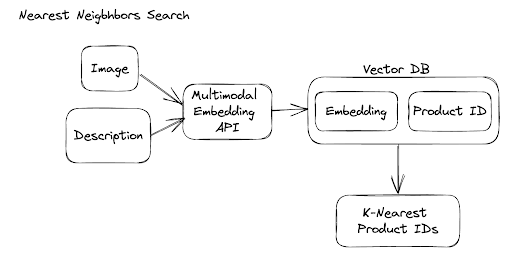



In [ ]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name=ENDPOINT_ID,
    project=PROJECT,
    location=LOCATION
)

In [ ]:
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='m92707982024_T', distance=0.46265918016433716)],
 [MatchNeighbor(id='m11961150187_I', distance=0.29012882709503174)]]

# 3. Join Category

The Vector DB does not contain reference information such as category. It only returns a product ID. We join this against the master product reference table in BigQuery

In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(PROJECT)

ids = [r.id[:-2] for neighbor in response for r in neighbor]
query = f"""
SELECT
  id,
  c0_name,
  c1_name,
  c2_name
FROM
  `{MASTER_PRODUCT_TABLE}`
WHERE
  id IN {str(ids).replace('[','(').replace(']',')')}
"""
query_job = bq_client.query(query)
rows = query_job.result()
categories = {}
for row in rows:
    categories[row['id']] = [row['c0_name'],row['c1_name'],row['c2_name']]
categories

{'m92707982024': ['Women', 'Shorts', None],
 'm11961150187': ['Men', 'Coats & jackets', 'Windbreaker']}

In [ ]:
# Sort results by embedding distance
candidates = [{'category':categories[r.id[:-2]],'id':r.id, 'distance':r.distance} for neighbor in response for r in neighbor]
sorted(candidates, key=lambda d: d['distance'])

[{'category': ['Men', 'Coats & jackets', 'Windbreaker'],
  'id': 'm11961150187_I',
  'distance': 0.29012882709503174},
 {'category': ['Women', 'Shorts', None],
  'id': 'm92707982024_T',
  'distance': 0.46265918016433716}]

# 4. Benchmark

Now that we've demonstrated vector based retrieval on a single example, let's evaluate the approach using our [golden test set](https://pantheon.corp.google.com/bigquery?ws=!1m5!1m4!4m3!1ssolutions-2023-mar-107!2smercari!3s13K_synthetic_attributes_embeddings_golden_test) containing ~100 examples.

The items in the test set are excluded from the vector database to simulate these being new/unkown items.



## Download Test Set

In [ ]:
query = f"""
  SELECT
    id,
    name,
    description,
    image_uri,
    c0_name,
    c1_name,
    c2_name,
    train_val_count
  FROM
    `{TEST_SET_TABLE}`
  WHERE
    manual_validation = 1 AND
    train_val_count >= 1
"""
df = bq_client.query(query).to_dataframe()

In [ ]:
df.head()

,id,name,description,image_uri,c0_name,c1_name,c2_name,train_val_count
0,m87595910019,Hot Sweat Sauna Body Shaper Women Slimmi,SAME DAY Free SHIPPING Hot Sweat Sauna Body ...,gs://genai-product-catalog/mercari_images_13K/...,Women,Underwear,Thermal underwear,1
1,m99091941411,Minnesota Twins Baseline Boppers Baseball Bobb...,Very good vintage condition. Set of 2 Minnesot...,gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Vintage & Antique Toys,Sports,1
2,m69723132745,Coach wristlet,Coach leather wristlet with Minnie Mouse on th...,gs://genai-product-catalog/mercari_images_13K/...,Handmade,Bags and purses,Wristlet,1
3,m18721424768,Fujifilm Instax Mini 11 Instant Film Camera in...,New Fujifilm Instax Mini 11 Instant Film Camer...,gs://genai-product-catalog/mercari_images_13K/...,Electronics,Cameras & photography,Film & Polaroid Cameras,2
4,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,Men,Shorts,Denim,2


## Add Labels

In [ ]:
CAT_COLS = ['c0_name','c1_name','c2_name']
NULL_REPL = 'Other' # fallback if column is null

def merge_category_names(row, cols: list[str], null_repl : str) -> str:
  """Given a row with individual category columns, combine"""
  return [row[col] if row[col] else null_repl for col in cols]

df["y_label"] = df.apply(lambda x: merge_category_names(x, CAT_COLS, NULL_REPL), axis=1)

In [ ]:
df.head()

,id,name,description,image_uri,c0_name,c1_name,c2_name,train_val_count,y_label
0,m87595910019,Hot Sweat Sauna Body Shaper Women Slimmi,SAME DAY Free SHIPPING Hot Sweat Sauna Body ...,gs://genai-product-catalog/mercari_images_13K/...,Women,Underwear,Thermal underwear,1,"[Women, Underwear, Thermal underwear]"
1,m99091941411,Minnesota Twins Baseline Boppers Baseball Bobb...,Very good vintage condition. Set of 2 Minnesot...,gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Vintage & Antique Toys,Sports,1,"[Toys & Collectibles, Vintage & Antique Toys, ..."
2,m69723132745,Coach wristlet,Coach leather wristlet with Minnie Mouse on th...,gs://genai-product-catalog/mercari_images_13K/...,Handmade,Bags and purses,Wristlet,1,"[Handmade, Bags and purses, Wristlet]"
3,m18721424768,Fujifilm Instax Mini 11 Instant Film Camera in...,New Fujifilm Instax Mini 11 Instant Film Camer...,gs://genai-product-catalog/mercari_images_13K/...,Electronics,Cameras & photography,Film & Polaroid Cameras,2,"[Electronics, Cameras & photography, Film & Po..."
4,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,Men,Shorts,Denim,2,"[Men, Shorts, Denim]"


## Get Predictions

Let's combine the embed, retrieval, and category join steps into a single function

In [ ]:
def gen_candidates(desc: str, image_uri: str, num_neighbors = 3):
  emb = embed(PROJECT,desc,image_uri)
  neighbors = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=num_neighbors,
  )
  ids = [r.id[:-2] for neighbor in neighbors for r in neighbor]
  query = f"""
    SELECT
      id,
      c0_name,
      c1_name,
      c2_name
    FROM
      `{MASTER_PRODUCT_TABLE}`
    WHERE
      id IN {str(ids).replace('[','(').replace(']',')')}
    """
  query_job = bq_client.query(query)
  rows = query_job.result()
  categories = {}
  for row in rows:
      categories[row['id']] = [row['c0_name'],row['c1_name'],row['c2_name']]
  candidates = [{'category':categories[r.id[:-2]],'id':r.id, 'distance':r.distance}
                  for neighbor in neighbors for r in neighbor]
  return sorted(candidates, key=lambda d: d['distance'])

In [ ]:
%%time
# Takes ~3 minutes
df["nearest_neighbors"] = df.apply(lambda x: gen_candidates(x['description'],x['image_uri'], num_neighbors=NUM_NEIGHBORS), axis=1)
df["y_pred_greedy"] = df["nearest_neighbors"].apply(lambda x: x[0]['category'])
df.to_pickle('test_df')
df.head()

CPU times: user 4.93 s, sys: 355 ms, total: 5.28 s
Wall time: 2min 52s


,id,name,description,image_uri,c0_name,c1_name,c2_name,train_val_count,y_label,nearest_neighbors,y_pred_greedy
0,m87595910019,Hot Sweat Sauna Body Shaper Women Slimmi,SAME DAY Free SHIPPING Hot Sweat Sauna Body ...,gs://genai-product-catalog/mercari_images_13K/...,Women,Underwear,Thermal underwear,1,"[Women, Underwear, Thermal underwear]","[{'category': ['Sports & outdoors', 'Exercise'...","[Sports & outdoors, Exercise, Fitness accessor..."
1,m99091941411,Minnesota Twins Baseline Boppers Baseball Bobb...,Very good vintage condition. Set of 2 Minnesot...,gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Vintage & Antique Toys,Sports,1,"[Toys & Collectibles, Vintage & Antique Toys, ...","[{'category': ['Sports & outdoors', 'Fan shop'...","[Sports & outdoors, Fan shop, NFL]"
2,m69723132745,Coach wristlet,Coach leather wristlet with Minnie Mouse on th...,gs://genai-product-catalog/mercari_images_13K/...,Handmade,Bags and purses,Wristlet,1,"[Handmade, Bags and purses, Wristlet]","[{'category': ['Handmade', 'Bags and purses', ...","[Handmade, Bags and purses, Wristlet]"
3,m18721424768,Fujifilm Instax Mini 11 Instant Film Camera in...,New Fujifilm Instax Mini 11 Instant Film Camer...,gs://genai-product-catalog/mercari_images_13K/...,Electronics,Cameras & photography,Film & Polaroid Cameras,2,"[Electronics, Cameras & photography, Film & Po...","[{'category': ['Electronics', 'Cell phones & a...","[Electronics, Cell phones & accessories, Cell ..."
4,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,Men,Shorts,Denim,2,"[Men, Shorts, Denim]","[{'category': ['Women', 'Shorts', 'Denim'], 'i...","[Women, Shorts, Denim]"


## Eval Metrics

We'll use hierarchical accuracy

In [ ]:
#TODO
def hierarchical_F1():
  pass

In [ ]:
def hierarchical_accuracy(y_pred: list[str], y_label: list[str]) -> float:
  """
  Get partial credit if some categories are correct.
  However  if a parent category is wrong, all children are
  considered wrong.
    Men->Shirts vs Women->Shirts would score 0 (parent category is wrong)
    Men->Shirts vs Men->Pants would score 0.5
    Men->Shirts vs Men->Shirts would score 1
  """
  n = len(y_pred)
  score = 0
  if n != len(y_label):
    raise ValueError(f'ERROR: length of prediction - {y_pred} and label - {y_label} must match.')
  for i in range(n):
    if y_pred[i] == y_label[i]:
      score += 1/n
    else:
      return score
  return score

In [ ]:
df["h_acc_greedy"] = df.apply(lambda x: hierarchical_accuracy(x["y_pred_greedy"],x["y_label"]), axis=1)
display(df.head())
print(f'Hierarchical Accuracy: {df["h_acc_greedy"].mean().round(3)}')

,id,name,description,image_uri,c0_name,c1_name,c2_name,train_val_count,y_label,nearest_neighbors,y_pred_greedy,h_acc_greedy,candidates,y_pred_llm,h_acc_llm
0,m87595910019,Hot Sweat Sauna Body Shaper Women Slimmi,SAME DAY Free SHIPPING Hot Sweat Sauna Body ...,gs://genai-product-catalog/mercari_images_13K/...,Women,Underwear,Thermal underwear,1,"[Women, Underwear, Thermal underwear]","[{'category': ['Sports & outdoors', 'Exercise'...","[Sports & outdoors, Exercise, Fitness accessor...",0.000000,"[[Sports & outdoors, Exercise, Fitness accesso...","[Sports & outdoors, Exercise, Fitness accessor...",0.000000
1,m99091941411,Minnesota Twins Baseline Boppers Baseball Bobb...,Very good vintage condition. Set of 2 Minnesot...,gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Vintage & Antique Toys,Sports,1,"[Toys & Collectibles, Vintage & Antique Toys, ...","[{'category': ['Sports & outdoors', 'Fan shop'...","[Sports & outdoors, Fan shop, NFL]",0.000000,"[[Sports & outdoors, Fan shop, NFL], [Toys & C...","[Toys & Collectibles, Action Figures & Accesso...",0.333333
2,m69723132745,Coach wristlet,Coach leather wristlet with Minnie Mouse on th...,gs://genai-product-catalog/mercari_images_13K/...,Handmade,Bags and purses,Wristlet,1,"[Handmade, Bags and purses, Wristlet]","[{'category': ['Handmade', 'Bags and purses', ...","[Handmade, Bags and purses, Wristlet]",1.000000,"[[Handmade, Bags and purses, Wristlet], [Women...","[Handmade, Bags and purses, Wristlet]",1.000000
3,m18721424768,Fujifilm Instax Mini 11 Instant Film Camera in...,New Fujifilm Instax Mini 11 Instant Film Camer...,gs://genai-product-catalog/mercari_images_13K/...,Electronics,Cameras & photography,Film & Polaroid Cameras,2,"[Electronics, Cameras & photography, Film & Po...","[{'category': ['Electronics', 'Cell phones & a...","[Electronics, Cell phones & accessories, Cell ...",0.333333,"[[Electronics, Cell phones & accessories, Cell...","[Electronics, Cameras & photography, Film & Po...",1.000000
4,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,Men,Shorts,Denim,2,"[Men, Shorts, Denim]","[{'category': ['Women', 'Shorts', 'Denim'], 'i...","[Women, Shorts, Denim]",0.000000,"[[Women, Shorts, Denim], [Women, Jeans, Straig...","[Women, Shorts, Denim]",0.000000


Hierarchical Accuracy: 0.603


# 5. Add LLM for Reranking

Let's see if we can improve upon the greed approach by asking and LLM to select from the Top K candidates based on a relvance to user description

In [ ]:
import vertexai
from vertexai.language_models import TextGenerationModel
vertexai.init(project=PROJECT, location=LOCATION)
parameters = {
    "max_output_tokens": 256,
    "temperature": 0.0,
}

## Prompt

Prompt engineering is more art than science but a couple notes that seem to improve results:
- Asking the LLM to explain its choice
- Telling it to stick to the list and not make up answers

In [ ]:
df['candidates'] = df['nearest_neighbors'].apply(lambda x: [[item if item else NULL_REPL for item in i['category']] for i in x])

In [ ]:
def llm_rerank(description: str, candidates: list[list[str]]) -> tuple[list[str], str]:
  """Return category and explanation"""

  query = "Based on the following description of a product can you identify which product category it belongs to from the candidates of categories: \n\n" + \
    "\n\n\n" + \
    "DESCRIPTION\n" + \
    description + \
    "\n\n" + \
    "PRODUCT CATEGORY CANDIDATES: \n\n" + \
    "\n".join(['->'.join(cat) for cat in candidates]) + \
    "\n\n" + \
    "INSTRUCTIONS:" + \
    "On the first line only respond with one of the category names from the PRODUCT CATEGORY CANDIDATES list, do not make up your own category. " + \
    "On the second line please explain why you think that is the right category based on the description " + \
    "\n\n" + \
    "ANSWER:" + \
    "The category name is: "



  model = TextGenerationModel.from_pretrained("text-bison")
  response = model.predict(
      query,
      **parameters
  )
  res = response.text.splitlines()
  if not res:
    raise ValueError('ERROR: no LLM response returned. This seems to be an intermittent bug')
  #print(f'Query:\n{query}')
  #print(f'LLM Response:\n {response}')
  formatted_res = res[0].lstrip().split('->')
  exp_len = len(candidates[0])
  if len(formatted_res) != exp_len:
    raise ValueError(f'ERROR: length of response - {formatted_res} and candidate - {candidates[0]} must match.')
  return formatted_res, res[1]

def llm_rerank_with_fallback(description: str, candidates: list[list[str]]) -> list[str]:
  """Wrapper around llm_rerank() to catch errors and return something sensible"""
  try:
    return llm_rerank(description, candidates)[0]
  except ValueError as e:
    print(e)
    print('Falling back to greedy approach. Taking nearest neighbor in embedding space.')
    return candidates[0]

In [ ]:
# Test single item
item = df.loc[df['id'] == 'm52791334307'].iloc[0]
print(item)
res = llm_rerank_with_fallback(item.description, item.candidates)
res

id                                                        m52791334307
name                 Torrid Ribbed Knit Open Cardigan Aqua Teal Plu...
description          Size: 6X Condition: Very good. Gently preowned...
image_uri            gs://genai-product-catalog/mercari_images_13K/...
c0_name                                                          Women
c1_name                                                       Sweaters
c2_name                                                       Cardigan
train_val_count                                                     87
y_label                                    [Women, Sweaters, Cardigan]
nearest_neighbors    [{'category': ['Women', 'Sweaters', 'Cardigan'...
y_pred_greedy                              [Women, Sweaters, Cardigan]
h_acc_greedy                                                       1.0
candidates           [[Women, Sweaters, Cardigan], [Handmade, Other...
Name: 62, dtype: object


['Women', 'Sweaters', 'Cardigan']

In [ ]:
%%time
#Run of Test Set, takes ~ 4min
def llm_rerank_show_id(x):
  print(x['id'])
  return llm_rerank_with_fallback(x['description'],x['candidates'])
df["y_pred_llm"] = df.apply(llm_rerank_show_id, axis=1)
df.head()

m87595910019
m99091941411
m69723132745
m18721424768
m56226905309
m67375259941
m50075005203
m46089184682
m49463353867
m35778537500
m68111706091
m92378019981
m58720747662
m73957582561
m19095076876
m74667116621
m17005963526
m29136799516
m11286305529
m30386798788
m49638171223
m36118961877
m92248813386
m96041370676
m45240971235
ERROR: length of response - ['Women', 'Skirts'] and candidate - ['Women', 'Pants', 'Dress pants'] must match.
Falling back to greedy approach. Taking nearest neighbor in embedding space.
m56480640733
m63169206254
m14193490298
m71053881699
m89634041528
m79376568013
m67616241887
m48519135167
m43709760924
m69736136382
m93277101692
m72339473394
m22339336180
m45786496295
m96667370583
m79293951119
m19995357182
ERROR: length of response - ["Men's accessories", 'Hats'] and candidate - ['Men', "Men's accessories", 'Hats'] must match.
Falling back to greedy approach. Taking nearest neighbor in embedding space.
m99218077564
m60469881152
m43112342002
m47326279114
m55816289103
ER

,id,name,description,image_uri,c0_name,c1_name,c2_name,train_val_count,y_label,nearest_neighbors,y_pred_greedy,h_acc_greedy,candidates,y_pred_llm
0,m87595910019,Hot Sweat Sauna Body Shaper Women Slimmi,SAME DAY Free SHIPPING Hot Sweat Sauna Body ...,gs://genai-product-catalog/mercari_images_13K/...,Women,Underwear,Thermal underwear,1,"[Women, Underwear, Thermal underwear]","[{'category': ['Sports & outdoors', 'Exercise'...","[Sports & outdoors, Exercise, Fitness accessor...",0.000000,"[[Sports & outdoors, Exercise, Fitness accesso...","[Sports & outdoors, Exercise, Fitness accessor..."
1,m99091941411,Minnesota Twins Baseline Boppers Baseball Bobb...,Very good vintage condition. Set of 2 Minnesot...,gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Vintage & Antique Toys,Sports,1,"[Toys & Collectibles, Vintage & Antique Toys, ...","[{'category': ['Sports & outdoors', 'Fan shop'...","[Sports & outdoors, Fan shop, NFL]",0.000000,"[[Sports & outdoors, Fan shop, NFL], [Toys & C...","[Toys & Collectibles, Action Figures & Accesso..."
2,m69723132745,Coach wristlet,Coach leather wristlet with Minnie Mouse on th...,gs://genai-product-catalog/mercari_images_13K/...,Handmade,Bags and purses,Wristlet,1,"[Handmade, Bags and purses, Wristlet]","[{'category': ['Handmade', 'Bags and purses', ...","[Handmade, Bags and purses, Wristlet]",1.000000,"[[Handmade, Bags and purses, Wristlet], [Women...","[Handmade, Bags and purses, Wristlet]"
3,m18721424768,Fujifilm Instax Mini 11 Instant Film Camera in...,New Fujifilm Instax Mini 11 Instant Film Camer...,gs://genai-product-catalog/mercari_images_13K/...,Electronics,Cameras & photography,Film & Polaroid Cameras,2,"[Electronics, Cameras & photography, Film & Po...","[{'category': ['Electronics', 'Cell phones & a...","[Electronics, Cell phones & accessories, Cell ...",0.333333,"[[Electronics, Cell phones & accessories, Cell...","[Electronics, Cameras & photography, Film & Po..."
4,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,Men,Shorts,Denim,2,"[Men, Shorts, Denim]","[{'category': ['Women', 'Shorts', 'Denim'], 'i...","[Women, Shorts, Denim]",0.000000,"[[Women, Shorts, Denim], [Women, Jeans, Straig...","[Women, Shorts, Denim]"


In [ ]:
def h_acc_catch_len_mismatch(x):
  try:
    return hierarchical_accuracy(x["y_pred_llm"],x["y_label"])
  except ValueError as e:
    print(e)
    return 0
df["h_acc_llm"] = df.apply(h_acc_catch_len_mismatch, axis=1)

import pandas as pd
display(df)
pd.set_option('display.max_rows', 150)

print(f'Hierarchical Accuracy: {df["h_acc_llm"].mean().round(3)}')

,id,name,description,image_uri,c0_name,c1_name,c2_name,train_val_count,y_label,nearest_neighbors,y_pred_greedy,h_acc_greedy,candidates,y_pred_llm,h_acc_llm
0,m87595910019,Hot Sweat Sauna Body Shaper Women Slimmi,SAME DAY Free SHIPPING Hot Sweat Sauna Body ...,gs://genai-product-catalog/mercari_images_13K/...,Women,Underwear,Thermal underwear,1,"[Women, Underwear, Thermal underwear]","[{'category': ['Sports & outdoors', 'Exercise'...","[Sports & outdoors, Exercise, Fitness accessor...",0.000000,"[[Sports & outdoors, Exercise, Fitness accesso...","[Sports & outdoors, Exercise, Fitness accessor...",0.000000
1,m99091941411,Minnesota Twins Baseline Boppers Baseball Bobb...,Very good vintage condition. Set of 2 Minnesot...,gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Vintage & Antique Toys,Sports,1,"[Toys & Collectibles, Vintage & Antique Toys, ...","[{'category': ['Sports & outdoors', 'Fan shop'...","[Sports & outdoors, Fan shop, NFL]",0.000000,"[[Sports & outdoors, Fan shop, NFL], [Toys & C...","[Toys & Collectibles, Action Figures & Accesso...",0.333333
2,m69723132745,Coach wristlet,Coach leather wristlet with Minnie Mouse on th...,gs://genai-product-catalog/mercari_images_13K/...,Handmade,Bags and purses,Wristlet,1,"[Handmade, Bags and purses, Wristlet]","[{'category': ['Handmade', 'Bags and purses', ...","[Handmade, Bags and purses, Wristlet]",1.000000,"[[Handmade, Bags and purses, Wristlet], [Women...","[Handmade, Bags and purses, Wristlet]",1.000000
3,m18721424768,Fujifilm Instax Mini 11 Instant Film Camera in...,New Fujifilm Instax Mini 11 Instant Film Camer...,gs://genai-product-catalog/mercari_images_13K/...,Electronics,Cameras & photography,Film & Polaroid Cameras,2,"[Electronics, Cameras & photography, Film & Po...","[{'category': ['Electronics', 'Cell phones & a...","[Electronics, Cell phones & accessories, Cell ...",0.333333,"[[Electronics, Cell phones & accessories, Cell...","[Electronics, Cameras & photography, Film & Po...",1.000000
4,m56226905309,Rough Natural Charm Streetwear Kawaii Denim Je...,GS02_040123_1 Preowned in used condition. Rar...,gs://genai-product-catalog/mercari_images_13K/...,Men,Shorts,Denim,2,"[Men, Shorts, Denim]","[{'category': ['Women', 'Shorts', 'Denim'], 'i...","[Women, Shorts, Denim]",0.000000,"[[Women, Shorts, Denim], [Women, Jeans, Straig...","[Women, Shorts, Denim]",0.000000
5,m67375259941,Mens FootJoy 1/4 Zip Tonal Heather Golf Pullov...,Size 2Xl Made in Vietnam 100% Polyester Tonal ...,gs://genai-product-catalog/mercari_images_13K/...,Men,Athletic apparel,Athletic Sweatshirts,2,"[Men, Athletic apparel, Athletic Sweatshirts]","[{'category': ['Women', 'Tops & blouses', 'Blo...","[Women, Tops & blouses, Blouse]",0.000000,"[[Women, Tops & blouses, Blouse], [Women, Athl...","[Women, Athletic apparel, Jackets]",0.000000
6,m50075005203,Cole Haan Lunar Grand Black Suede Comfort Oxfords,black suede Lunar Grand Wingtip Comfort Oxford...,gs://genai-product-catalog/mercari_images_13K/...,Women,Shoes,Oxfords,2,"[Women, Shoes, Oxfords]","[{'category': ['Men', 'Shoes', 'Oxfords'], 'id...","[Men, Shoes, Oxfords]",0.000000,"[[Men, Shoes, Oxfords], [Men, Shoes, Oxfords]]","[Men, Shoes, Oxfords]",0.000000
7,m46089184682,VALENTINES **TIFFANY** STACKABLES**NWT,"BRAND NEW *TIFFANY* STACKABLES ""ORIGINAL SQUIS...",gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Collectibles & Hobbies,Squishies,3,"[Toys & Collectibles, Collectibles & Hobbies, ...","[{'category': ['Toys & Collectibles', 'Stuffed...","[Toys & Collectibles, Stuffed Animals & Plush,...",0.333333,"[[Toys & Collectibles, Stuffed Animals & Plush...","[Toys & Collectibles, Stuffed Animals & Plush,...",0.333333
8,m49463353867,Pokemon Celebrations Premium Playmat Collectio...,Pokémon Celebrations 25th Anniversary Pikachu ...,gs://genai-product-catalog/mercari_images_13K/...,Toys & Collectibles,Trading Cards,Trading Card Boxes,3,"[Toys & Collectibles, Trading Cards, Trading C...","[{'category': ['Toys & Col

Hierarchical Accuracy: 0.71


# Summary of Results

Hierarchical Accuracy
- 0.60: Greedy Retrieval
- 0.71: LLM Rerank - num_neighbors=1
- 0.74: LLM Rerank - num_neighbors=2
- 0.76: LLM Rerank - num_neighbors=3
- 0.78: LLM Rerank - num_neighbors=5
- 0.78: LLM Rerank - num_neighbors=7
- 0.79: LLM Rerank - num_neighbors=10
- 0.79: LLM Rerank - num_neighbors=20
- 0.80: LLM Rerank - num_neighbors=40
- 0.79: LLM Rerank - num_neigbhors=80

*Note we fetch num_neigbhors for BOTH text and image imbeddings, resulting in (2 * num_neigbhors) candidates fed to the LLM prompt.

It's interesting to note the LLM can handle 80 candidates before loosing accuracy.

With the current prompt, ~3% of the time the LLM will return a malformed answer. In these cases we default to the greedy result. These metrics may change as `text-bison` is updated.